In [86]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.linewidth'] = 2 # set the value globally
plt.rcParams['figure.dpi'] = 150

## `Maxwell Damping` in FLAC Command

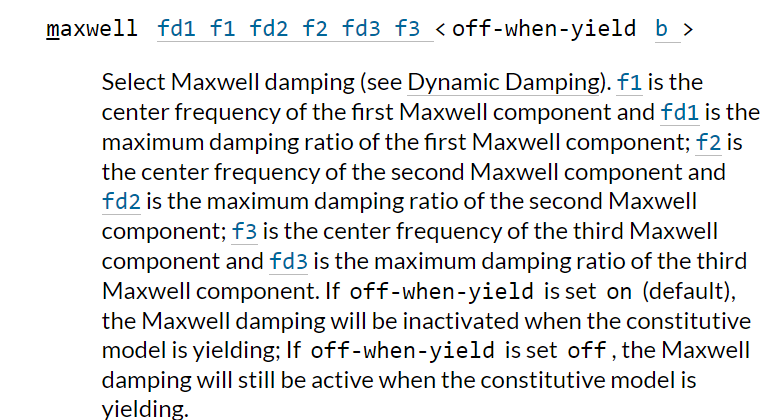

In [87]:
def get_maxwell_real(d_max, f_max, freq_maxwell):
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    print(f'alpha_k={alpha_k}, tak_k={tao_k}')
    omega_maxwell = 2 * math.pi * freq_maxwell
    return alpha_k * tao_k**2*omega_maxwell**2 / (1 + tao_k**2*omega_maxwell**2)

def get_maxwell_imag(d_max, f_max, freq_maxwell):
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    omega_maxwell = 2 * math.pi * freq_maxwell
    return alpha_k * tao_k*omega_maxwell / (1 + tao_k**2*omega_maxwell**2)

In [88]:
def get_single_maxwell_component(f_max: float, 
                                d_max: float, 
                                freq_maxwell: np.ndarray) -> np.ndarray:
    """Calculates the single frequency response from a maxwell component in a dynamic system

    Args:
        f_max (float): Frequency coresponding to the maximum damping ratio 
        - [Hz]
        d_max (float): Maximum damping ratio. -[decimal] consistent with 
        FLAC input
        freq_maxwell (np.ndarray): Array of frequencies for the Maxwell 
        component. -[Hz]
    Returns:
        damping_maxwell (np.ndarray): Array of damping ratios corresponding to 
        the frequencies. -[%]
    """
    alpha_k = 8 * d_max**2 + 4 * d_max * np.sqrt(2 * d_max**2 +1)
    tao_k = 1 / (2 * math.pi * f_max * np.sqrt(1 + alpha_k))
    print(f'alpha_k={alpha_k}, tak_k={tao_k}')
    omega_maxwell = 2 * math.pi * freq_maxwell
    damping_maxwell = alpha_k * tao_k * omega_maxwell / ( 2 + 2*(1 + alpha_k) * tao_k**2 * omega_maxwell**2) * 100 # -[%]
    return damping_maxwell

def get_flac_maxwell(fd1: float, f1: float, 
                    fd2: float, f2: float, 
                    fd3: float, f3: float) -> pd.DataFrame:
    freq_band = np.logspace(-2, 3, num=800)
    
    fd_all = [fd1, fd2, fd3]
    f_all = [f1, f2, f3]
    df = pd.DataFrame()
    
    for index, (freq, fd) in enumerate(zip(f_all, fd_all)):
        # get response of each component
        xi_maxwell = get_single_maxwell_component(freq, fd, freq_band)
        df_single = pd.DataFrame({f'd_max_{index}': xi_maxwell})
        df = pd.concat([df, df_single], axis=1)
    
    df['freq_band'] = freq_band

    real_sum = np.zeros(len(freq_band))
    imag_sum = np.zeros(len(freq_band))
    for index, (freq, fd) in enumerate(zip(f_all, fd_all)):
        #get the total response
        d_max_real = get_maxwell_real(fd, freq, freq_band)
        d_max_imag = get_maxwell_imag(fd, freq, freq_band)
        real_sum += d_max_real
        imag_sum += d_max_imag
    real_sum += 1
    d_max_all = imag_sum/2/real_sum*100
    df['d_max_all'] = d_max_all

    return df['d_max_all'] , freq_band, df

### Single Maxwell Component

alpha_k=0.16608609757628473, tak_k=0.14738552163240287
alpha_k=0.16608609757628473, tak_k=0.14738552163240287


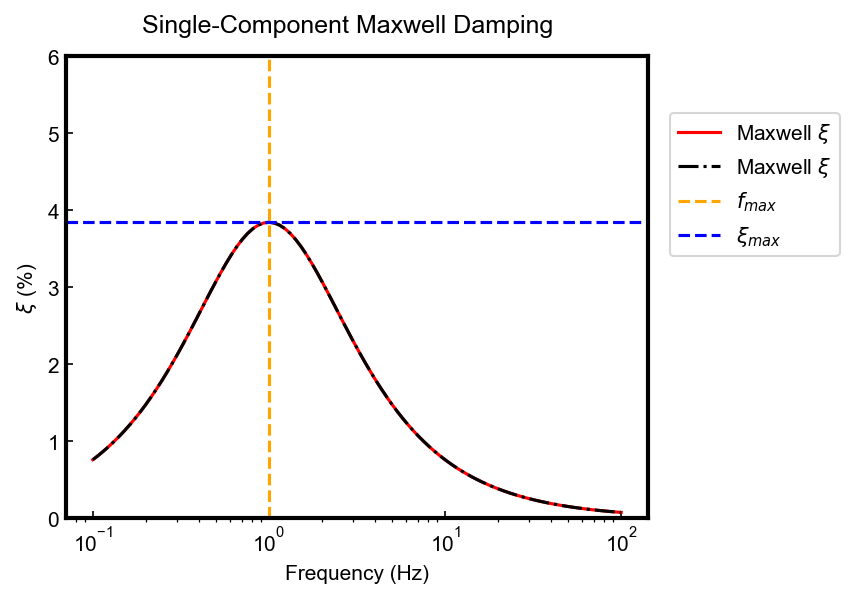

In [89]:
target_damping = 3.85 #-[%]
freq_band = np.logspace(-1, 2, num=100)
f = 1.0
d = target_damping/100.0
damping_maxwell = get_single_maxwell_component(f, d, freq_band)
d_max_real = get_maxwell_real(d, f, freq_band) + 1
d_max_imag = get_maxwell_imag(d, f, freq_band)

d_max = d_max_imag/d_max_real/2*100

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
fig.suptitle('Single-Component Maxwell Damping', fontsize=12, y=0.95)
ax.semilogx(freq_band, damping_maxwell, color='red',label=r'Maxwell $\xi$')
ax.semilogx(freq_band, d_max, color='k',ls='-.', label=r'Maxwell $\xi$')
ax.axvline(x=f, color='orange',ls='--',label='$f_{max}$')
ax.axhline(y=d*100, color='blue',ls='--',label=r'$\xi_{max}$')
ax.set_ylim(0, 6)
ax.set_ylabel(r'$\xi$ (%)')
ax.set_xlabel('Frequency (Hz)')
ax.tick_params(axis='both', direction='in')
ax.legend(bbox_to_anchor=(1.02, 0.9), loc='upper left')

### `FLAC` Inputs 

In [90]:
fd1 = 3.85/100
f1 = 0.5
fd2 = 3.35/100
f2 = 3.5
fd3 = 5.2/100
f3 = 25
target_damping = 5.0

alpha_k=0.16608609757628473, tak_k=0.29477104326480574
alpha_k=0.1431282972117468, tak_k=0.04253090260421838
alpha_k=0.23019367364115587, tak_k=0.0057397553076160195
alpha_k=0.16608609757628473, tak_k=0.29477104326480574
alpha_k=0.1431282972117468, tak_k=0.04253090260421838
alpha_k=0.23019367364115587, tak_k=0.0057397553076160195


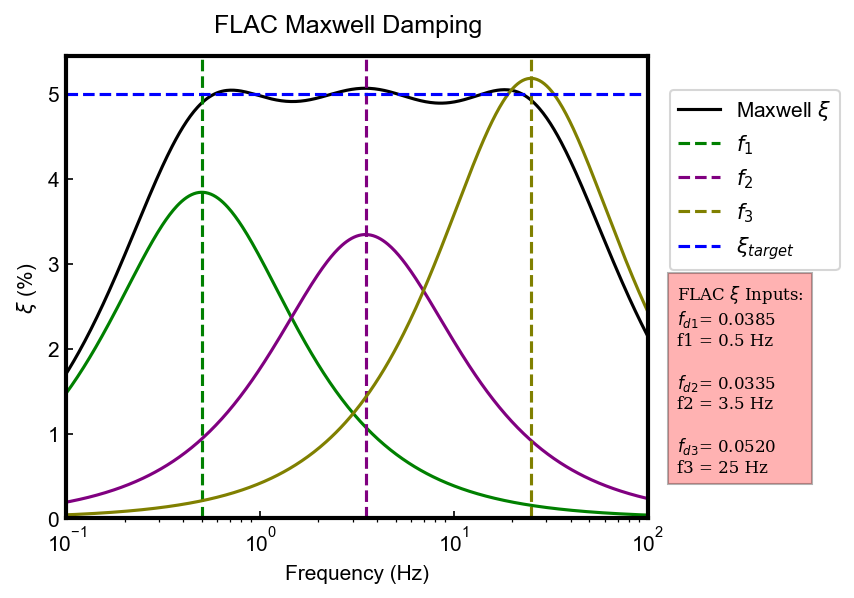

In [95]:
fd_all= [fd1, fd2, fd3]
f_all = [f1, f2, f3]

color_list = ['green', 'purple', 'olive']
damping_maxwell, freq_band, df = get_flac_maxwell(fd1, f1, fd2, f2, fd3, f3)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
fig.suptitle('FLAC Maxwell Damping', fontsize=12, y=0.95)
ax.semilogx(freq_band, damping_maxwell, color='k',label=r'Maxwell $\xi$')
d_maxwell_columns = ['d_max_0', 'd_max_1', 'd_max_2']

for index, (col, freq) in enumerate(zip(d_maxwell_columns, f_all)):
        xi_maxwell = df[col].iloc[:]
        ax.semilogx(freq_band, xi_maxwell, color=color_list[index])
        ax.axvline(x=freq, label=f'$f_{index+1}$', color=color_list[index], ls='--')

ax.axhline(y=target_damping, color='blue',ls='--',label=r'$\xi_{target}$')
ax.set_xlim(0.1, 100)
ax.set_ylim(0, None)
ax.set_ylabel(r'$\xi$ (%)')
ax.set_xlabel('Frequency (Hz)')
ax.tick_params(axis='both', direction='in')
ax.legend(bbox_to_anchor=(1.02, 0.95), loc='upper left')
t = str(r"FLAC $\xi$ Inputs:" +
    "\n$f_{d1}$" +f"= {fd1:.4f}\nf1 = {f1} Hz" +
    f'\n ' +
    "\n$f_{d2}$" + f"= {fd2:.4f}\nf2 = {f2} Hz" +
    f'\n '
    "\n$f_{d3}$" + f"= {fd3:.4f}\nf3 = {f3} Hz")

ax.text(1.05, 0.1, t, bbox=dict(facecolor='red', alpha=0.3), 
    transform=ax.transAxes, family='serif', size=8)
plt.show()
plt.close()

### Dawson & Chen (2021)

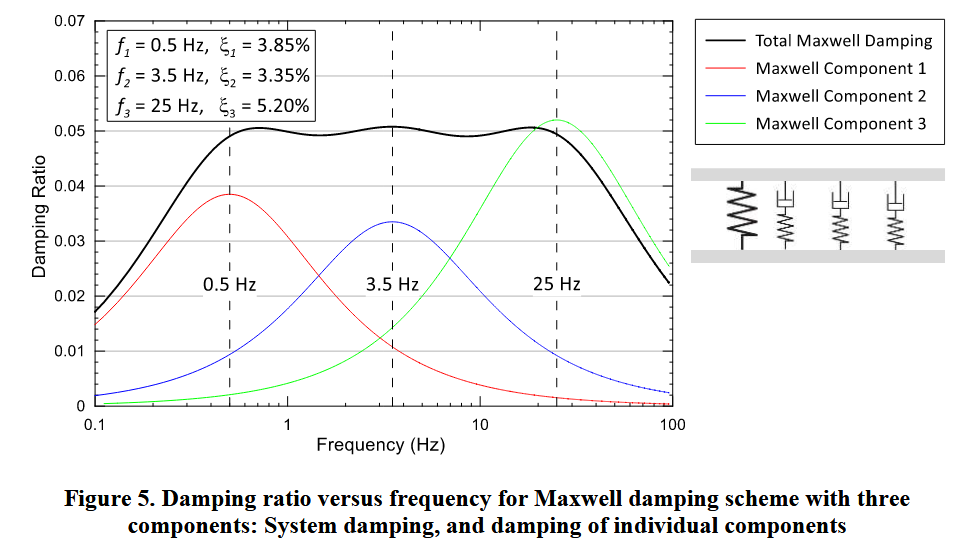